<a href="https://colab.research.google.com/github/kianakiaei/TensorFlow/blob/main/03_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing car in front

## Get the data

Because convolutional neural networks work so well with images, to learn more about them, we're going to start with a dataset of images.

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.


> 🔑 **Note:** To prepare the data we're using, preprocessing steps such as, moving the images into different subset folders, have been done. To see these preprocessing steps check out [the preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We'll download the `pizza_steak` subset .zip file and unzip it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.6.0
TF Hub version: 0.12.0
GPU available (YESSSS!!!!!)


In [2]:
import zipfile

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-09-24 10:15:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.50M   197MB/s    in 0.5s    

2021-09-24 10:15:19 (197 MB/s) - ‘pizza_steak.zip’ saved [109579078/109579078]



## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.


In [3]:
!ls pizza_steak

test  train


In [4]:
!ls pizza_steak/train/

pizza  steak


In [5]:
!ls pizza_steak/train/steak/ 

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [6]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in 'pizza_steak'.
There are 2 directories and 1 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 2 directories and 1 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.


In [7]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [8]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
class_names = class_names[1:] # for remove '.DS_Store'
print(class_names)

['pizza' 'steak']


> 🤔 **Note:** Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Visualize, visualize, visualize.**

In [9]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + "/" + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


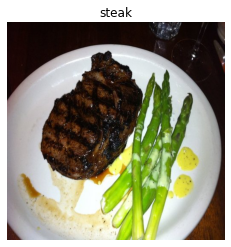

In [10]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train",
                        target_class="steak")

Image shape: (512, 512, 3)


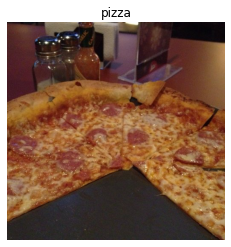

In [11]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train",
                        target_class="pizza")

In [12]:
# View the image shape
img.shape # returns (width, height, colour channels)

(512, 512, 3)

In [13]:
# View the img (actually just a big array/tensor)
img

array([[[ 38,  22,  23],
        [ 36,  20,  21],
        [ 35,  21,  21],
        ...,
        [ 12,   9,  16],
        [ 10,   7,  14],
        [  8,   5,  12]],

       [[ 43,  24,  26],
        [ 39,  20,  22],
        [ 38,  19,  21],
        ...,
        [ 12,   9,  16],
        [ 11,   8,  15],
        [ 11,   8,  15]],

       [[ 52,  27,  30],
        [ 50,  25,  28],
        [ 46,  24,  26],
        ...,
        [ 13,   8,  15],
        [ 15,  10,  17],
        [ 16,  11,  18]],

       ...,

       [[ 44,  40,  39],
        [ 44,  40,  37],
        [ 43,  39,  36],
        ...,
        [152, 116,  80],
        [152, 118,  80],
        [157, 123,  85]],

       [[ 43,  39,  36],
        [ 43,  39,  36],
        [ 42,  38,  35],
        ...,
        [144, 105,  72],
        [156, 120,  84],
        [159, 124,  86]],

       [[ 40,  36,  33],
        [ 40,  36,  33],
        [ 40,  36,  33],
        ...,
        [120,  79,  47],
        [145, 107,  71],
        [148, 113,  75]]

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [14]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.14901961, 0.08627451, 0.09019608],
        [0.14117647, 0.07843137, 0.08235294],
        [0.1372549 , 0.08235294, 0.08235294],
        ...,
        [0.04705882, 0.03529412, 0.0627451 ],
        [0.03921569, 0.02745098, 0.05490196],
        [0.03137255, 0.01960784, 0.04705882]],

       [[0.16862745, 0.09411765, 0.10196078],
        [0.15294118, 0.07843137, 0.08627451],
        [0.14901961, 0.0745098 , 0.08235294],
        ...,
        [0.04705882, 0.03529412, 0.0627451 ],
        [0.04313725, 0.03137255, 0.05882353],
        [0.04313725, 0.03137255, 0.05882353]],

       [[0.20392157, 0.10588235, 0.11764706],
        [0.19607843, 0.09803922, 0.10980392],
        [0.18039216, 0.09411765, 0.10196078],
        ...,
        [0.05098039, 0.03137255, 0.05882353],
        [0.05882353, 0.03921569, 0.06666667],
        [0.0627451 , 0.04313725, 0.07058824]],

       ...,

       [[0.17254902, 0.15686275, 0.15294118],
        [0.17254902, 0.15686275, 0.14509804],
        [0.16862745, 0

## An end-to-end example

Let's build a convolutional neural network to find patterns inour images, more specifically we need a way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 45s 261ms/step - loss: 0.5518 - accuracy: 0.7140 - val_loss: 0.4196 - val_accuracy: 0.8240
Epoch 2/5
47/47 [==============================] - 11s 231ms/step - loss: 0.4135 - accuracy: 0.8180 - val_loss: 0.3578 - val_accuracy: 0.8560
Epoch 3/5
47/47 [==============================] - 11s 232ms/step - loss: 0.3917 - accuracy: 0.8147 - val_loss: 0.3241 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 11s 231ms/step - loss: 0.3625 - accuracy: 0.8527 - val_loss: 0.2948 - val_accuracy: 0.8760
Epoch 5/5
47/47 [==============================] - 11s 232ms/step - loss: 0.3132 - accuracy: 0.8653 - val_loss: 0.3260 - val_accuracy: 0.8540


In [16]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

> spend 10-minutes playing around the incredible [CNN explainer website](https://poloclub.github.io/cnn-explainer/).

## Using the same model as before - non CNN model

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 10s 211ms/step - loss: 0.7278 - accuracy: 0.4960 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 9s 201ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 10s 205ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 9s 202ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 9s 203ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


our model ran but it doesn't seem like it learned anything. It only reaches 50% accuracy on the training and test sets which in a binary classification problem is as good as guessing.

In [18]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20xmore parameters than our CNN (model_1), model_2 performs terrubly... Let's try to improve it.

In [19]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 10s 212ms/step - loss: 4.6175 - accuracy: 0.6253 - val_loss: 0.6862 - val_accuracy: 0.7100
Epoch 2/5
47/47 [==============================] - 10s 206ms/step - loss: 0.7374 - accuracy: 0.7240 - val_loss: 0.8013 - val_accuracy: 0.7000
Epoch 3/5
47/47 [==============================] - 10s 205ms/step - loss: 1.0389 - accuracy: 0.6987 - val_loss: 0.4725 - val_accuracy: 0.7940
Epoch 4/5
47/47 [==============================] - 10s 206ms/step - loss: 0.6568 - accuracy: 0.7353 - val_loss: 0.4899 - val_accuracy: 0.7800
Epoch 5/5
47/47 [==============================] - 10s 209ms/step - loss: 0.5217 - accuracy: 0.7700 - val_loss: 0.4554 - val_accuracy: 0.7900


In [20]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


the number of trainable parameters has increased even more than `model_2`. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, `model_3` still doesn't out perform `model_1`.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## Binary classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model, the main step here was scsling/normalizing & turning our data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied (experiment, experiment, experiment...)


### 1. Become one with the data

Image shape: (512, 512, 3)
Image shape: (511, 512, 3)


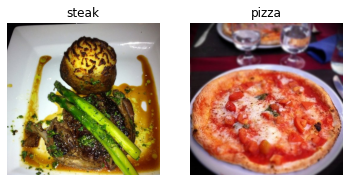

In [21]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train", "pizza")

### 2. Preprocess the data (prepare it for a model)

In [22]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**.

A **batch** is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

There are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for each of our datasets.

In [23]:
# Create train and test data generators and rescale the data 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [24]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               target_size=(224, 224), # Target size of images (height, width)
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [25]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [26]:
# How many batches are there?
len(train_data)

47

In [27]:
1500/32

46.875

In [28]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

Due to our `rescale` parameter, the images are now in `(224, 224, 3)` shape tensors with values between 0 and 1.

In [29]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a model (start with a baseline)

To begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note:** In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In [30]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [31]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, # filter is the number of sliding windows going across an input (higher = more complex model)
         kernel_size=3, # the size of the sliding window going across an input. can write as tuple like (3, 3)
         strides=1, # the size of the step of the sliding window takes across an input. can write as tuple like (1, 1)
         padding='valid', # if "same", output shape is same as input shape, if "valid", output shape gets compressed
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (working with binary classification so only 1 output neuron)
])

We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

```
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
```

Let's discuss some of the components of the `Conv2D` layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

In [32]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [33]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten_3 (Flatten)          (None, 475240)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 475241    
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


input shape is (224, 224, 3). Since the padding is valid, the output shape will be (222, 222, 3)

### 4. Fit a model

two new parameters here:
* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [34]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [35]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 13s 251ms/step - loss: 1.2211 - accuracy: 0.6673 - val_loss: 0.4736 - val_accuracy: 0.8060
Epoch 2/5
47/47 [==============================] - 11s 233ms/step - loss: 0.4587 - accuracy: 0.8033 - val_loss: 0.4125 - val_accuracy: 0.8220
Epoch 3/5
47/47 [==============================] - 11s 236ms/step - loss: 0.3323 - accuracy: 0.8693 - val_loss: 0.3904 - val_accuracy: 0.8100
Epoch 4/5
47/47 [==============================] - 11s 230ms/step - loss: 0.1540 - accuracy: 0.9487 - val_loss: 0.4638 - val_accuracy: 0.8020
Epoch 5/5
47/47 [==============================] - 11s 234ms/step - loss: 0.0726 - accuracy: 0.9773 - val_loss: 0.5820 - val_accuracy: 0.7680


In [36]:
model_1.evaluate(test_data)

16/16 [==============================] - 3s 158ms/step - loss: 0.3260 - accuracy: 0.8540


[0.32602283358573914, 0.8539999723434448]

`model_1` is better than `model_4`

In [37]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

### 5. Evaluation our model

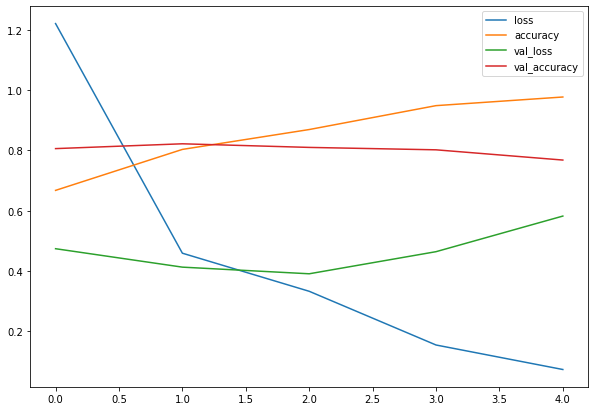

In [38]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished.

In [39]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

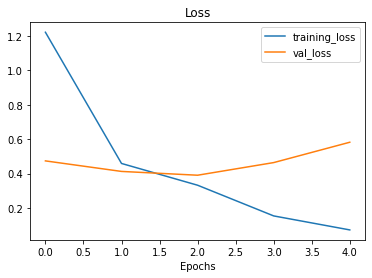

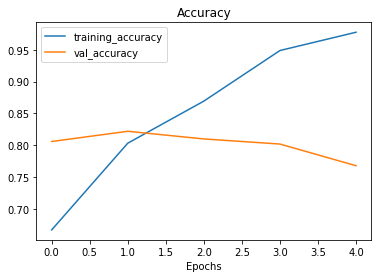

In [40]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.